In [1]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=cfbd7c0798daa262d47b2cd2500ee3e18ad6e381e1548c6d98bd13c7b4945e3e
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


1. Create a Spark session

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession \
.builder \
.appName("Assignment3") \
.config("spark.some.config.option", "some-value") \
.getOrCreate()


2. Define the schema for loading the Chicago crime dataset

In [3]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, TimestampType, FloatType
schema = StructType([
StructField("ID", IntegerType(), True),
StructField("CaseNumber", StringType(), True),
StructField("Date", StringType(), True),
StructField("Block", StringType(), True),
StructField("IUCR", StringType(), True),
StructField("PrimaryType", StringType(), True),
StructField("Description", StringType(), True),
StructField("LocationDescription", StringType(), True),
StructField("Arrest", StringType(), True),
StructField("Domestic", StringType(), True),
StructField("Beat", IntegerType(), True),
StructField("District", IntegerType(), True),
StructField("Ward", IntegerType(), True),
StructField("CommunityArea", IntegerType(), True),
StructField("FBICode", StringType(), True),
StructField("XCoordinate", FloatType(), True),
StructField("YCoordinate", FloatType(), True),
StructField("Year", IntegerType(), True),
StructField("UpdatedOn", TimestampType(), True),
StructField("Latitude", FloatType(), True),
StructField("Longitude", FloatType(), True),
StructField("Location", StringType(), True)
])

Downloading the data

In [4]:
!curl -o myData.csv https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  257M    0  257M    0     0  2644k      0 --:--:--  0:01:39 --:--:-- 3037k^C


Import and load the Chicago crime dataset (you should get more than a million rows) using the specified schema

In [7]:
df = spark.read.csv("myData.csv", header=True, schema=schema)

df.show(20)

+--------+----------+--------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+---------+---------+----------+--------------------+
|      ID|CaseNumber|                Date|               Block|IUCR|       PrimaryType|         Description| LocationDescription|Arrest|Domestic|Beat|District|Ward|CommunityArea|FBICode|XCoordinate|YCoordinate|Year|UpdatedOn| Latitude| Longitude|            Location|
+--------+----------+--------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+---------+---------+----------+--------------------+
|11037294|  JA371270|03/18/2015 12:00:...|   0000X W WACKER DR|1153|DECEPTIVE PRACTICE|FINANCIAL IDENTIT...|                BANK| false|   false| 111|       1|  42|           32|     11|       NUL

In [16]:
num_rows = df.count()
num_cols = len(df.columns)
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")


Number of rows: 1139570
Number of columns: 22


In [17]:
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- CaseNumber: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- PrimaryType: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- LocationDescription: string (nullable = true)
 |-- Arrest: string (nullable = true)
 |-- Domestic: string (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: integer (nullable = true)
 |-- Ward: integer (nullable = true)
 |-- CommunityArea: integer (nullable = true)
 |-- FBICode: string (nullable = true)
 |-- XCoordinate: float (nullable = true)
 |-- YCoordinate: float (nullable = true)
 |-- Year: integer (nullable = true)
 |-- UpdatedOn: timestamp (nullable = true)
 |-- Latitude: float (nullable = true)
 |-- Longitude: float (nullable = true)
 |-- Location: string (nullable = true)



4.Cleaning the data:

a. Removing all the null values.

b. Change 'Date' column data type

In [30]:
from pyspark.sql.functions import *


df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()


+---+----------+----+-----+----+-----------+-----------+-------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+---------+--------+---------+--------+
| ID|CaseNumber|Date|Block|IUCR|PrimaryType|Description|LocationDescription|Arrest|Domestic|Beat|District|Ward|CommunityArea|FBICode|XCoordinate|YCoordinate|Year|UpdatedOn|Latitude|Longitude|Location|
+---+----------+----+-----+----+-----------+-----------+-------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+---------+--------+---------+--------+
|  0|         0|   0|    0|   0|          0|          0|                  0|     0|       0|   0|       2|   0|            0|      0|          0|          0|   0|  1139570|   23495|    23495|   23495|
+---+----------+----+-----+----+-----------+-----------+-------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+---------+--------+---------+-----

In [31]:
mean_value = df.select(mean('LocationDescription')).collect()[0][0]
df = df.fillna(str(mean_value), subset=['LocationDescription'])
mean_value = df.select(mean('Ward')).collect()[0][0]
df = df.fillna(int(mean_value), subset=['Ward'])
mean_value = df.select(mean('XCoordinate')).collect()[0][0]
df = df.fillna(float(mean_value), subset=['XCoordinate'])
mean_value = df.select(mean('YCoordinate')).collect()[0][0]
df = df.fillna(float(mean_value), subset=['YCoordinate'])
mean_value = df.select(mean('CommunityArea')).collect()[0][0]
df = df.fillna(int(mean_value), subset=['CommunityArea'])
print((df.count(), len(df.columns)))


(1139570, 22)


In [32]:
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()


+---+----------+----+-----+----+-----------+-----------+-------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+---------+--------+---------+--------+
| ID|CaseNumber|Date|Block|IUCR|PrimaryType|Description|LocationDescription|Arrest|Domestic|Beat|District|Ward|CommunityArea|FBICode|XCoordinate|YCoordinate|Year|UpdatedOn|Latitude|Longitude|Location|
+---+----------+----+-----+----+-----------+-----------+-------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+---------+--------+---------+--------+
|  0|         0|   0|    0|   0|          0|          0|                  0|     0|       0|   0|       2|   0|            0|      0|          0|          0|   0|  1139570|   23495|    23495|   23495|
+---+----------+----+-----+----+-----------+-----------+-------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+---------+--------+---------+-----

In [33]:
df = df.withColumn("UpdatedOn",df["UpdatedOn"].cast(StringType()))
mean_value = df.select(mean('UpdatedOn')).collect()[0][0]
df = df.fillna(str(mean_value), subset=['UpdatedOn'])


df.printSchema()


root
 |-- ID: integer (nullable = true)
 |-- CaseNumber: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- PrimaryType: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- LocationDescription: string (nullable = false)
 |-- Arrest: string (nullable = true)
 |-- Domestic: string (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: integer (nullable = true)
 |-- Ward: integer (nullable = true)
 |-- CommunityArea: integer (nullable = true)
 |-- FBICode: string (nullable = true)
 |-- XCoordinate: float (nullable = false)
 |-- YCoordinate: float (nullable = false)
 |-- Year: integer (nullable = true)
 |-- UpdatedOn: string (nullable = false)
 |-- Latitude: float (nullable = true)
 |-- Longitude: float (nullable = true)
 |-- Location: string (nullable = true)



In [34]:
mean_value = df.select(mean('Latitude')).collect()[0][0]
df = df.fillna(float(mean_value), subset=['Latitude'])
mean_value = df.select(mean('Longitude')).collect()[0][0]
df = df.fillna(float(mean_value), subset=['Longitude'])
mean_value = df.select(mean('Location')).collect()[0][0]
df = df.fillna(str(mean_value), subset=['Location'])

df = df.na.drop()

df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+---+----------+----+-----+----+-----------+-----------+-------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+---------+--------+---------+--------+
| ID|CaseNumber|Date|Block|IUCR|PrimaryType|Description|LocationDescription|Arrest|Domestic|Beat|District|Ward|CommunityArea|FBICode|XCoordinate|YCoordinate|Year|UpdatedOn|Latitude|Longitude|Location|
+---+----------+----+-----+----+-----------+-----------+-------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+---------+--------+---------+--------+
|  0|         0|   0|    0|   0|          0|          0|                  0|     0|       0|   0|       0|   0|            0|      0|          0|          0|   0|        0|       0|        0|       0|
+---+----------+----+-----+----+-----------+-----------+-------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+---------+--------+---------+-----

In [35]:
print((df.count(), len(df.columns)))

(231720, 22)

df.printSchema()

(1139568, 22)
root
 |-- ID: integer (nullable = true)
 |-- CaseNumber: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- PrimaryType: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- LocationDescription: string (nullable = false)
 |-- Arrest: string (nullable = true)
 |-- Domestic: string (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: integer (nullable = true)
 |-- Ward: integer (nullable = true)
 |-- CommunityArea: integer (nullable = true)
 |-- FBICode: string (nullable = true)
 |-- XCoordinate: float (nullable = false)
 |-- YCoordinate: float (nullable = false)
 |-- Year: integer (nullable = true)
 |-- UpdatedOn: string (nullable = false)
 |-- Latitude: float (nullable = false)
 |-- Longitude: float (nullable = false)
 |-- Location: string (nullable = false)



In [36]:
df.show(20)


+--------+----------+--------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+---------+---------+----------+--------------------+
|      ID|CaseNumber|                Date|               Block|IUCR|       PrimaryType|         Description| LocationDescription|Arrest|Domestic|Beat|District|Ward|CommunityArea|FBICode|XCoordinate|YCoordinate|Year|UpdatedOn| Latitude| Longitude|            Location|
+--------+----------+--------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+---------+---------+----------+--------------------+
|11037294|  JA371270|03/18/2015 12:00:...|   0000X W WACKER DR|1153|DECEPTIVE PRACTICE|FINANCIAL IDENTIT...|                BANK| false|   false| 111|       1|  42|           32|     11|  1164887.

In [37]:
df = df.withColumn("Date", to_timestamp("Date", "MM/dd/yyyy hh:mm:ss a"))
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- CaseNumber: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- PrimaryType: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- LocationDescription: string (nullable = false)
 |-- Arrest: string (nullable = true)
 |-- Domestic: string (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: integer (nullable = true)
 |-- Ward: integer (nullable = true)
 |-- CommunityArea: integer (nullable = true)
 |-- FBICode: string (nullable = true)
 |-- XCoordinate: float (nullable = false)
 |-- YCoordinate: float (nullable = false)
 |-- Year: integer (nullable = true)
 |-- UpdatedOn: string (nullable = false)
 |-- Latitude: float (nullable = false)
 |-- Longitude: float (nullable = false)
 |-- Location: string (nullable = false)



In [38]:
from pyspark.sql.functions import year, current_date
from datetime import datetime, timedelta
current_date = datetime.now()
ten_years_ago = current_date - timedelta(days=365*10)
print(ten_years_ago.year)

2013

filtered_df = df.filter(col("Year") >= int(ten_years_ago.year))
min_value = filtered_df.agg(min(col("Year"))).collect()[0][0]
min_value



2013


2013

6.Remove all the records with the following crime types: 'NON-CRIMINAL (SUBJECT SPECIFIED)' 'OTHER OFFENSE' 'STALKING' 'NON -
CRIMINAL'


In [39]:
df = filtered_df.filter(col("PrimaryType").isin([
"NON-CRIMINAL (SUBJECT SPECIFIED)",
"OTHER OFFENSE",
"STALKING",
"NON - CRIMINAL",
"ARSON"
]) == False)
df.show(5)


+--------+----------+-------------------+--------------------+----+------------------+--------------------+-------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+---------+---------+---------+--------+
|      ID|CaseNumber|               Date|               Block|IUCR|       PrimaryType|         Description|LocationDescription|Arrest|Domestic|Beat|District|Ward|CommunityArea|FBICode|XCoordinate|YCoordinate|Year|UpdatedOn| Latitude|Longitude|Location|
+--------+----------+-------------------+--------------------+----+------------------+--------------------+-------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+---------+---------+---------+--------+
|11037294|  JA371270|2015-03-18 12:00:00|   0000X W WACKER DR|1153|DECEPTIVE PRACTICE|FINANCIAL IDENTIT...|               BANK| false|   false| 111|       1|  42|           32|     11|  1164887.6|  1885939.0|2015|     None|41.842606|-87.6704

7.Merge the similar crime types. For example, change 'Primary Type' of cases that have 'Primary Type' as ‘SEX OFFENSE’ or ‘PROSTITUTION’
such that they should have the same 'Primary Type'.


In [51]:
df.select('PrimaryType').distinct().show(150, False)


+---------------------------------+
|PrimaryType                      |
+---------------------------------+
|OFFENSE INVOLVING CHILDREN       |
|CRIMINAL SEXUAL ASSAULT          |
|PUBLIC PEACE VIOLATION           |
|OBSCENITY                        |
|GAMBLING                         |
|CRIMINAL TRESPASS                |
|ASSAULT                          |
|LIQUOR LAW VIOLATION             |
|MOTOR VEHICLE THEFT              |
|THEFT                            |
|BATTERY                          |
|ROBBERY                          |
|HOMICIDE                         |
|RITUALISM                        |
|PUBLIC INDECENCY                 |
|CRIM SEXUAL ASSAULT              |
|HUMAN TRAFFICKING                |
|INTIMIDATION                     |
|PROSTITUTION                     |
|DECEPTIVE PRACTICE               |
|CONCEALED CARRY LICENSE VIOLATION|
|SEX OFFENSE                      |
|CRIMINAL DAMAGE                  |
|NARCOTICS                        |
|NON-CRIMINAL               

In [41]:
merged_df = df.withColumn(
"MergedPrimaryType",
when(
(col("PrimaryType") == "SEX OFFENSE") | (col("PrimaryType") == "PROSTITUTION"),
"SEX OFFENSE/PROSTITUTION"
).when(
(col("PrimaryType") == "BURGLARY") | (col("PrimaryType") == "ROBBERY") | (col("PrimaryType") == "THEFT"),
"BURGLARY/ROBBERY/THEFT"
).otherwise(col("PrimaryType"))
)

In [42]:
merged_df.show(100)


+--------+----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+---------+---------+----------+--------------------+--------------------+
|      ID|CaseNumber|               Date|               Block|IUCR|         PrimaryType|         Description| LocationDescription|Arrest|Domestic|Beat|District|Ward|CommunityArea|FBICode|XCoordinate|YCoordinate|Year|UpdatedOn| Latitude| Longitude|            Location|   MergedPrimaryType|
+--------+----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+---------+---------+----------+--------------------+--------------------+
|11037294|  JA371270|2015-03-18 12:00:00|   0000X W WACKER DR|1153|  DECEPTIVE PRACTICE|FINANCIAL IDENTIT...|                BANK|

In [43]:
result1 = merged_df.groupBy("Year").count().orderBy("Year")
result1.show()


+----+------+
|Year| count|
+----+------+
|2013|   267|
|2014|   362|
|2015|   621|
|2016|   704|
|2017|   838|
|2018|  1596|
|2019|  2099|
|2020| 64680|
|2021|192955|
|2022|214044|
|2023| 77327|
+----+------+



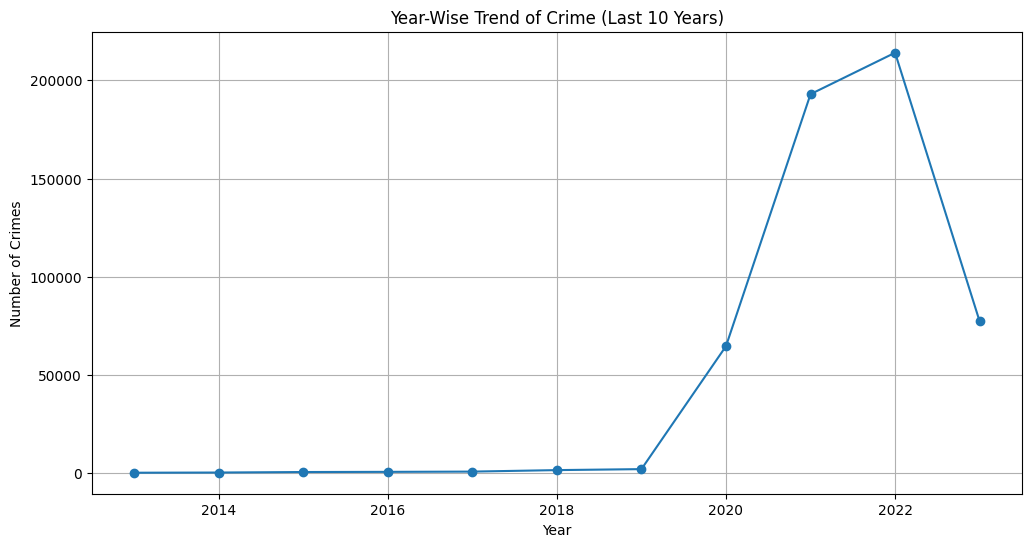

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
result1_pd = result1.toPandas()
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(result1_pd["Year"], result1_pd["count"], marker='o', linestyle='-')
plt.title('Year-Wise Trend of Crime (Last 10 Years)')
plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.grid(True)
plt.show()



In [45]:
result2 = merged_df.groupBy(hour(col("Date")).alias("hour")).count().orderBy(desc("count"))
result2.show(24)


+----+-----+
|hour|count|
+----+-----+
|   0|43826|
|  12|32809|
|  15|29422|
|  17|29388|
|  18|28624|
|  16|28539|
|  19|28130|
|  20|27810|
|  14|26272|
|  21|25855|
|  13|25245|
|  22|24718|
|   9|24399|
|  11|24376|
|  10|24227|
|  23|22379|
|   8|18448|
|   1|18115|
|   2|16114|
|   3|13424|
|   7|13263|
|   4|10831|
|   6| 9978|
|   5| 9301|
+----+-----+



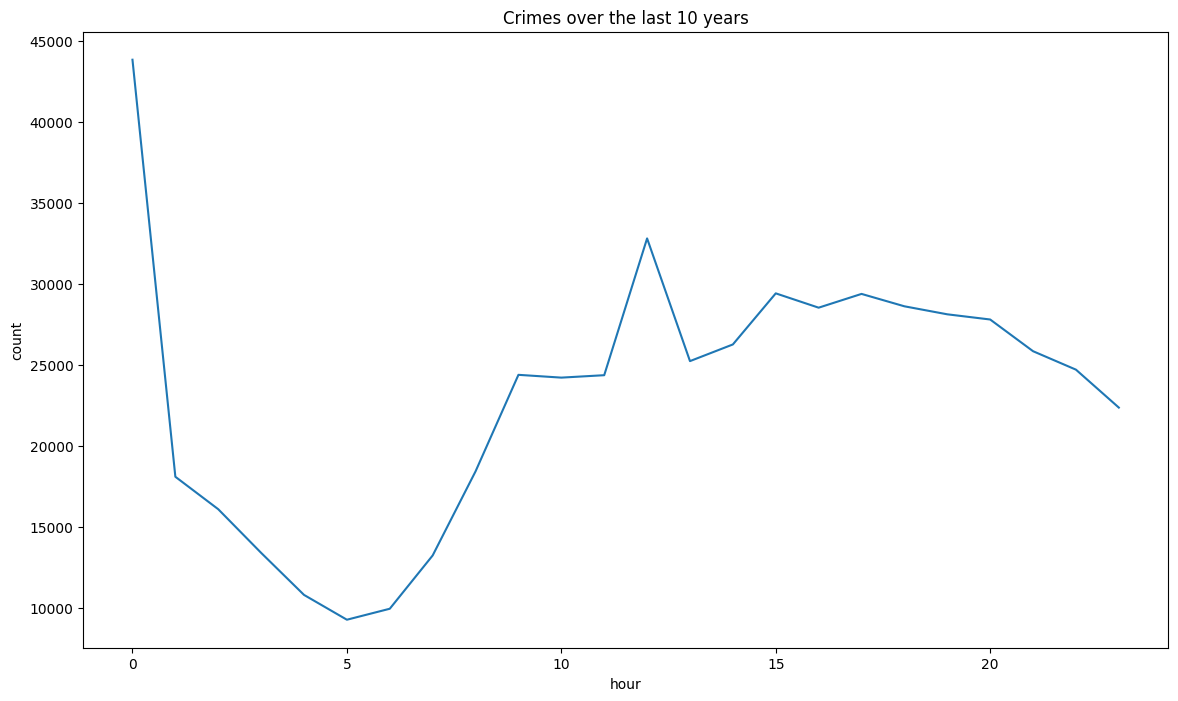

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd  # Import Pandas library

# Assuming result2 is your DataFrame
# Use Pandas to convert the DataFrame to a Pandas DataFrame
result2 = pd.DataFrame(result2)

plt.figure(figsize=(14, 8))
sns.lineplot(data=result2, x='hour', y='count')
plt.title('Crimes over the last 10 years')

plt.show()




In [60]:
result3 = merged_df.groupBy('MergedPrimaryType').count()
result3 =result3.toPandas()
result3 = result3.sort_values(by= 'count',ascending = False).head(10)
result3


,MergedPrimaryType,count
4,BURGLARY/ROBBERY/THEFT,166549
10,BATTERY,106827
20,CRIMINAL DAMAGE,68719
7,ASSAULT,53384
18,DECEPTIVE PRACTICE,49487
9,MOTOR VEHICLE THEFT,44158
24,WEAPONS VIOLATION,23247
21,NARCOTICS,13936
6,CRIMINAL TRESPASS,10277
0,OFFENSE INVOLVING CHILDREN,5885


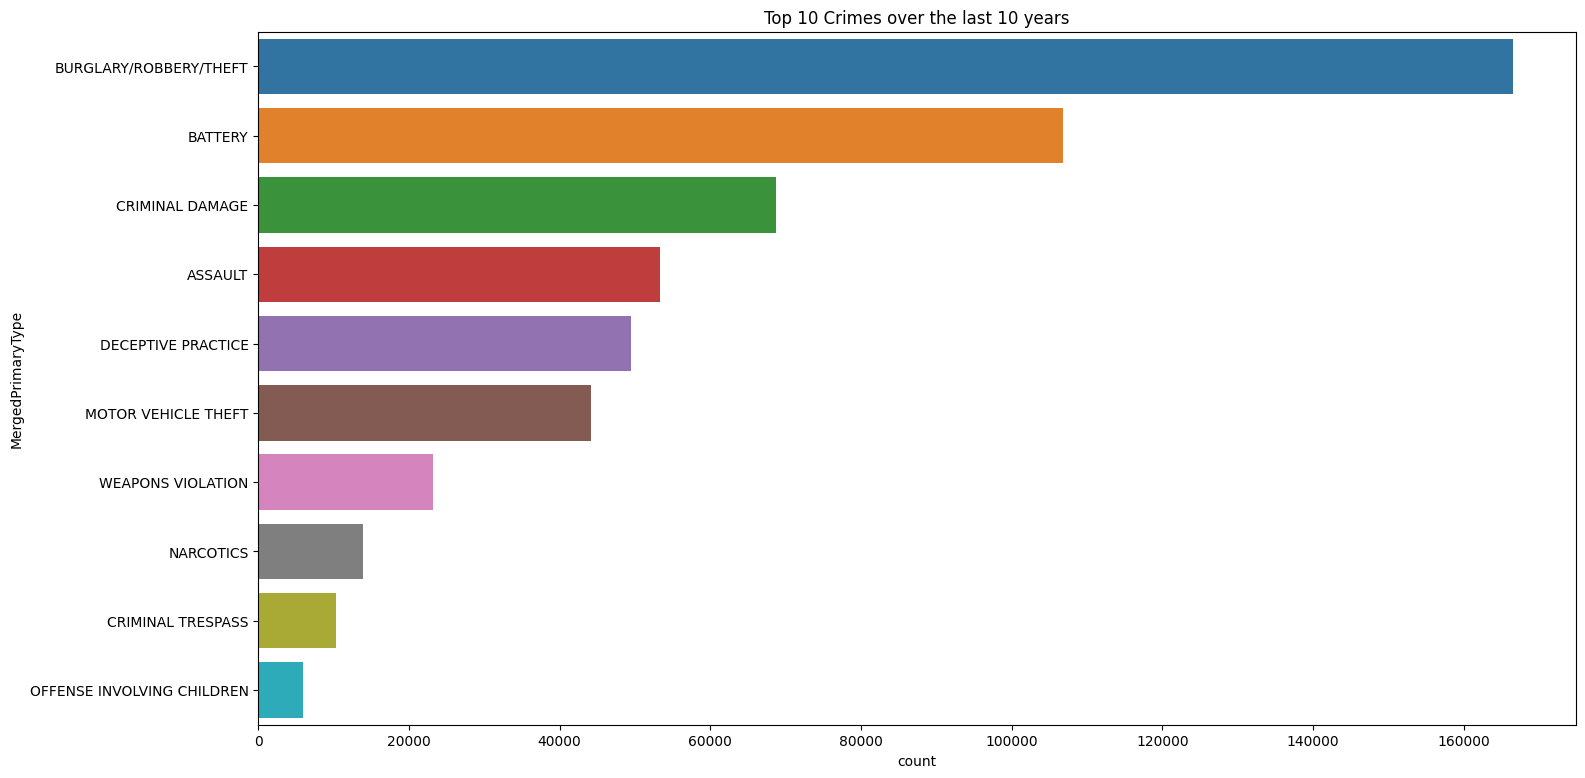

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(17, 9))
sns.barplot(data=result3, x='count', y='MergedPrimaryType')
plt.title('Top 10 Crimes over the last 10 years')

plt.show()

